In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
import numpy as np
import os
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt
import math
import scipy

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def get_data_set(target_directory, target_filename, verbose = True):
    X_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainX.csv"), delimiter=',')
    Y_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainY.csv"), delimiter=',')
    
    if verbose:
        print('Succesfully imported dataset with of size {0}'.format(X_data.shape))
    
    return (X_data, Y_data)

In [ ]:
(X_data, Y_data) = get_data_set(target_directory = './resources/run_2', target_filename = 'full')

rangefinder_bearings = np.arange(0, 20)/19.0*math.pi-math.pi/2

Succesfully imported dataset with of size (1943053, 20)


In [5]:
def evaluate_predictions(Y_data, Y_predicted):
    
    """
    Compares the predicted output against the training output via a violin plot.
    
    :param Y_data Output from training set.
    :param Y_predicted Output predicted by machine learning algorithm.
    :return None
    """
    
    y_buckets = sorted(set(Y_data))
    
    d=dict()
    for b in y_buckets:
        d[b] = Y_predicted[Y_data == b]

    fig2, ax2 = plt.subplots()
    ax2.violinplot(d.values(), positions = d.keys(), showmeans = True, showextrema = False)
    ax2.set_xlabel('DP Controller')
    ax2.set_ylabel('Reactive Controller')
    ax2.set_ylim([min(y_buckets), max(y_buckets)])
    ax2.set_aspect('equal')
    plt.show()

In [29]:
def run_linear_regression(
    X_data, 
    Y_data, 
    fit_intercept = True, 
    Y_weighting_function = None,
    X_transform = (lambda x: x),
    Y_transform = (lambda x: x), 
    Y_inverse_transform = (lambda x: x)):
    
    assert np.all(Y_inverse_transform(Y_transform(Y_data)) == Y_data), "Composing transform and inverse transform does not return identity function."
        
    if Y_weighting_function == None:
        sample_weight = None
    else:
        sample_weight = Y_weighting_function(Y_data)
    
    Xt_data = X_transform(X_data)
    Yt_data = Y_transform(Y_data)
    
    lr = sklearn.linear_model.LinearRegression(fit_intercept = fit_intercept)
    lr.fit(Xt_data, Yt_data, sample_weight)
    
    print ("Regression weights for features = ")
    print lr.coef_
    
    print ("Intercept = ")
    print lr.intercept_
    
    print ("r-value")
    print lr.score(Xt_data, Yt_data, sample_weight)
    
#     fig1, ax1 = plt.subplots()
#     ax1.scatter(rangefinder_bearings, lr.coef_)
#     plt.show()
    
    Yt_predicted = lr.predict(Xt_data)
    Y_predicted = Y_inverse_transform(Yt_predicted)

    return Y_predicted

Regression weights for features = 
[-0.03095658 -0.01949426 -0.02677003 -0.03462618 -0.04171019 -0.05536625
 -0.07269059 -0.08088806 -0.07962131 -0.03693672  0.03636901  0.08357396
  0.08290121  0.0689061   0.05494826  0.04255617  0.03428646  0.02521712
  0.0174142   0.02976362]
Intercept = 
0.06311237307
r-value
0.593026257835


<IPython.core.display.Javascript object>


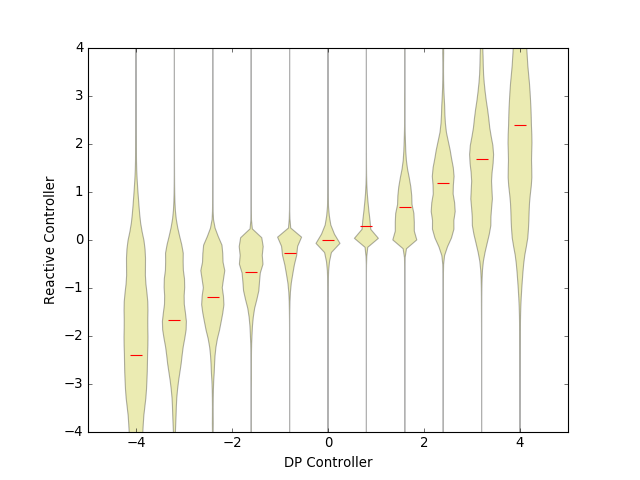

In [24]:
# linear features

Y_predicted = run_linear_regression(
    X_data, 
    Y_data, 
    Y_weighting_function = lambda Y_data: np.abs(Y_data)**6)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[-0.12820739 -0.11653007 -0.18012205 -0.29509318 -0.43459486 -0.64483216
 -0.93072812 -1.14679293 -1.19636129 -0.62109231  0.61424212  1.24851301
  1.16859892  0.89921882  0.64799494  0.43062646  0.28780376  0.17586158
  0.10444544  0.13586271]
Intercept = 
-0.339876818562
r-value
0.507934341117


<IPython.core.display.Javascript object>


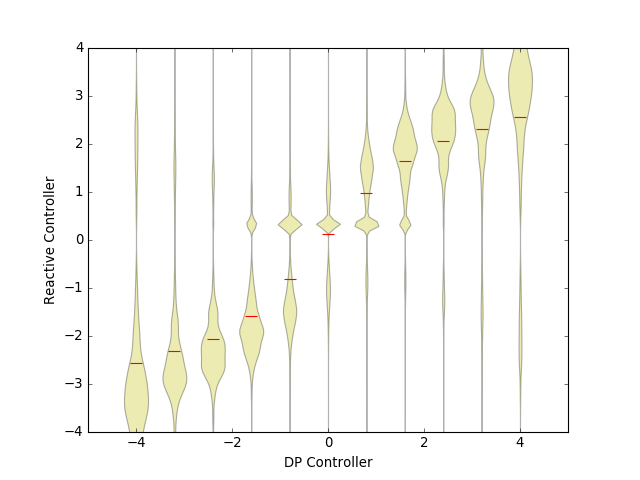

In [25]:
# cubed objective, no centering of features

Y_predicted = run_linear_regression(
    X_data, 
    Y_data, 
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y))

evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[-0.12933211 -0.1168573  -0.18053814 -0.29548549 -0.43497715 -0.64520728
 -0.93109957 -1.14716128 -1.19673222 -0.62145319  0.61387357  1.24814345
  1.16823557  0.89885198  0.64761157  0.430246    0.28741517  0.17543379
  0.10411869  0.13474329]
Intercept = 
0.0
r-value
0.507933296073


<IPython.core.display.Javascript object>


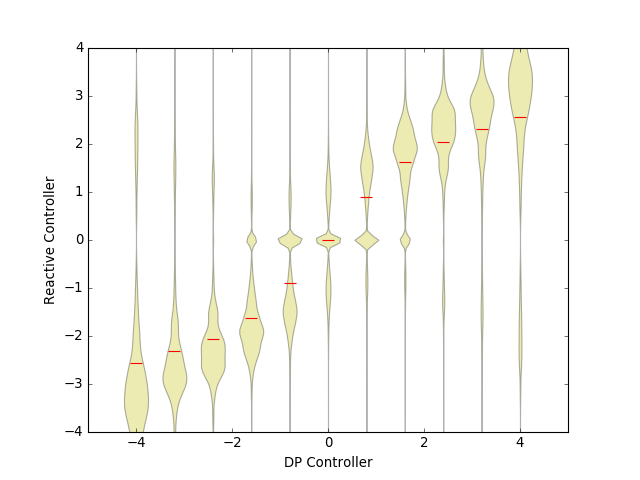

In [26]:
# cubed objective with centering of features: this forces the controller to do nothing when there are no obstacles in view.

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    fit_intercept = False,
    X_transform = lambda x: x - np.max(x),
    Y_transform = lambda y: np.power(y, 3),
    Y_inverse_transform = lambda y: scipy.special.cbrt(y))

evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[-0.00486087  0.02011026 -0.04758648  0.03816886  0.01386825 -0.0267182
  0.03875477 -0.31041366  0.47561949 -0.10997544 -0.1635306   0.29882722
 -0.42632099  0.26411668 -0.11601514  0.03176974  0.04839641 -0.03124584
  0.00886904 -0.00165036]
Intercept = 
0.00392811737885
r-value
0.000880152752372


<IPython.core.display.Javascript object>


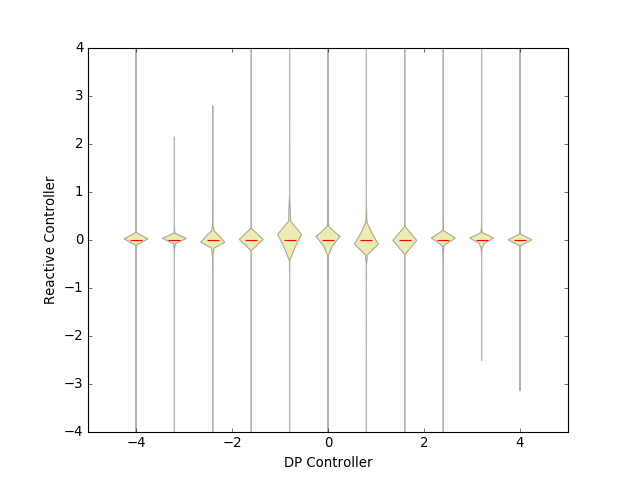

In [39]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: x**(-1))
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[ 0.55688734  0.09715581  0.23268801  0.32779648  0.46424846  0.73174422
  1.34451046  2.08094596  2.50626798  1.21588408 -1.2050314  -2.56087022
 -2.15060049 -1.22946668 -0.78952948 -0.47952402 -0.29455699 -0.19412673
 -0.10274636 -0.59078567]
Intercept = 
0.00647812594772
r-value
0.16574154878


<IPython.core.display.Javascript object>


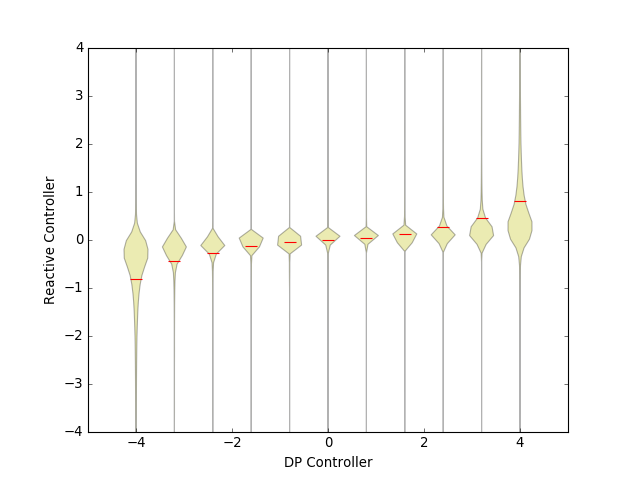

In [27]:
# attempt at inverse controller. It's not so good.

def inverse_features(X_data):
    X_features = X_data**(-1)
    cap = np.array([1])
    X_capped = np.minimum(cap, X_features)
    return X_capped

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = inverse_features)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[ -3.70701568e-05  -3.31134497e-05  -4.72047254e-05  -6.65803186e-05
  -8.92859021e-05  -1.18183952e-04  -1.49033180e-04  -1.68242418e-04
  -1.55532780e-04  -8.21952125e-05   8.17933236e-05   1.62554882e-04
   1.69652361e-04   1.47029209e-04   1.17848702e-04   8.81150824e-05
   6.51334693e-05   4.64984000e-05   3.20510366e-05   3.85980793e-05]
Intercept = 
-0.0174724111189
r-value
0.60553934502


<IPython.core.display.Javascript object>


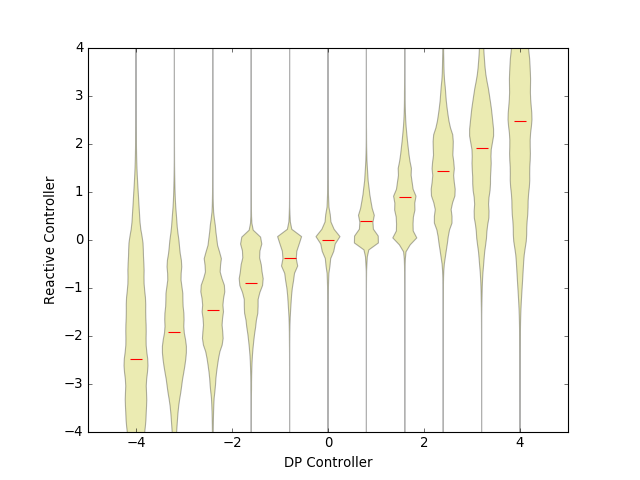

In [28]:
# cubed features. 

Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: x**3)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[  0.00000000e+00  -3.18126831e-02  -2.04993966e-03  -2.64848987e-03
   1.98646138e-02   4.76638926e-02   6.83033885e-02   8.13378414e-02
   1.08098828e-01   1.32309097e-01   1.19591970e-01  -1.23882172e-01
  -1.51279989e-01  -8.55215857e-02  -8.49943365e-02  -6.06100312e-02
  -3.44576222e-02  -1.20066446e-02   2.51659985e-03   4.98699867e-03
   2.89655322e-02   3.03542613e-03  -1.50152863e-03  -6.30361533e-04
  -1.08009688e-03  -8.64827141e-04  -2.97226298e-04  -3.29240189e-04
  -3.55422447e-04  -4.28127940e-04   6.86359022e-04   7.79292429e-04
   3.32094283e-05  -3.83713905e-04   5.88253567e-05   1.36554172e-04
  -1.45649466e-04   1.01793685e-05   7.31539105e-06   1.21844669e-04
  -1.90695586e-04   1.63090871e-03  -1.65945746e-03   7.19148729e-05
  -6.89739611e-04  -5.48073798e-04  -1.98250406e-04  -2.28638082e-04
   3.17696978e-04  -8.32990432e-05   6.35053110e-04  -1.47881144e-04
   1.42429271e-04  -3.70602367e-05  -1.84544640e-04   1.72045945e-04

<IPython.core.display.Javascript object>


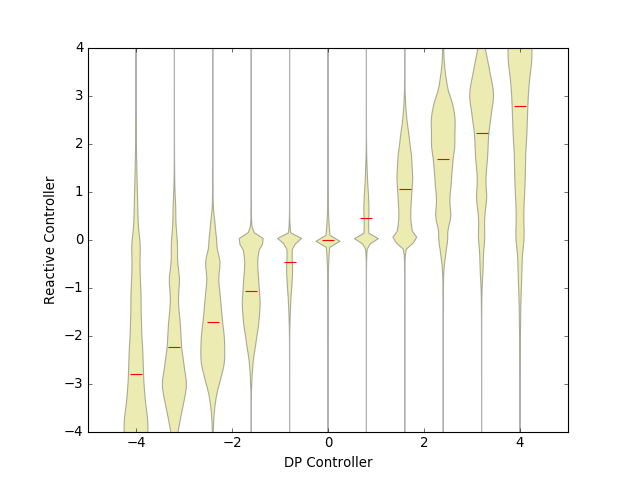

In [38]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: sklearn.preprocessing.PolynomialFeatures(degree = 2).fit_transform(x))
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[ -6.42448407e-05  -2.91037674e-05  -4.83991364e-05  -7.08763750e-05
  -8.88989642e-05  -1.22482378e-04  -1.80007386e-04  -2.39824108e-04
  -2.72900213e-04  -1.31122951e-04   1.27860041e-04   2.82353832e-04
   2.46981065e-04   1.68376143e-04   1.27355287e-04   8.92050790e-05
   6.81735997e-05   4.58010627e-05   2.85365716e-05   6.49919535e-05]
Intercept = 
0.0
r-value
0.326500827542


<IPython.core.display.Javascript object>


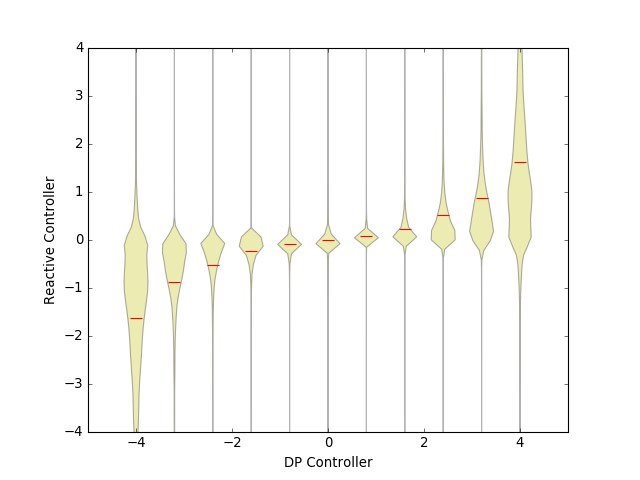

In [37]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    fit_intercept = False,
    X_transform = lambda x: (x-np.max(x))**3)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[-0.04502725 -0.03642967 -0.06687173 -0.1195575  -0.17425543 -0.27121378
 -0.42946446 -0.57687262 -0.65707628 -0.35090794  0.34059889  0.68901295
  0.58764733  0.40414137  0.27933993  0.17415406  0.11165395  0.06325257
  0.03365957  0.0514234 ]
Intercept = 
-0.017022596707
r-value
0.326244747505


<IPython.core.display.Javascript object>


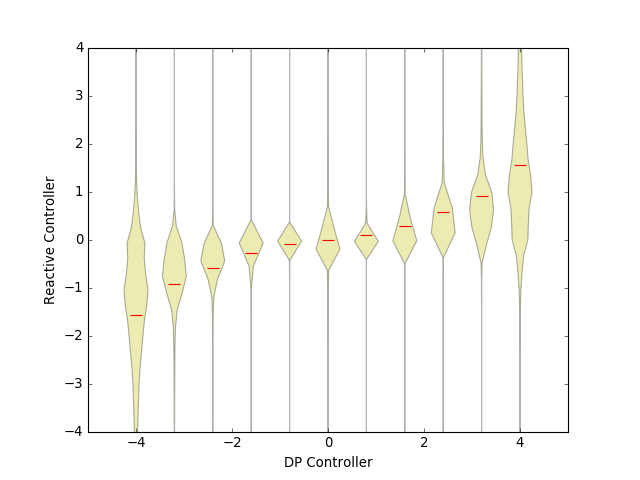

In [34]:
Y_predicted = run_linear_regression(
    X_data, 
    Y_data,
    X_transform = lambda x: np.log(x))
evaluate_predictions(Y_data, Y_predicted)

<IPython.core.display.Javascript object>


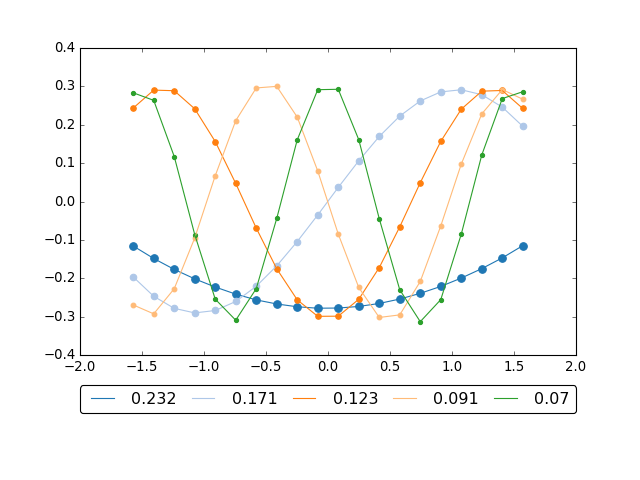

In [137]:
skpca = sklearn.decomposition.PCA().fit(X_data)
visualize_principal_components(skpca, range(5))

Succesfully imported dataset with of size (194614, 20)


<IPython.core.display.Javascript object>


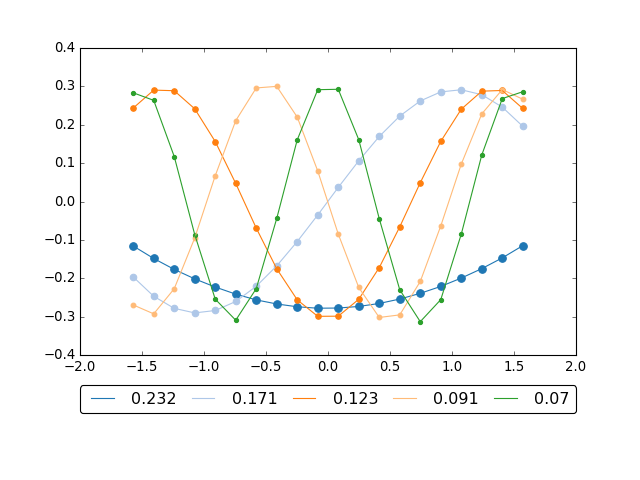

In [142]:
(X_data2, Y_data2) = get_data_set(target_directory = './resources/run_1', target_filename = 'small')
skpca2 = sklearn.decomposition.PCA().fit(X_data2)
visualize_principal_components(skpca2, range(5))

In [ ]:
(X_data3, Y_data3) = get_data_set(target_directory = './resources/run_3', target_filename = 'small')
skpca3 = sklearn.decomposition.PCA().fit(X_data3)
visualize_principal_components(skpca3, range(5))

Succesfully imported dataset with of size (187030, 20)


In [10]:
def visualize_principal_components(pca, selected_principal_components):

    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)

    lines = []
    label_text = map(lambda x: round(x, 3), (pca.explained_variance_ratio_[i] for i in selected_principal_components))

    fig1, ax1 = plt.subplots()
    for i in selected_principal_components:
        line, = ax1.plot(rangefinder_bearings, pca.components_[i], color = tableau20[i])
        lines.append(line)
        ax1.scatter(rangefinder_bearings, pca.components_[i], s = pca.explained_variance_ratio_[i]*200, color = tableau20[i])

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.2,
                     box.width, box.height * 0.8])

    ax1.legend(
        lines, 
        label_text, 
        bbox_to_anchor=(.0, -0.2, 1., .102), 
        loc='upper center',
        ncol=5, 
        mode="expand", 
        fancybox = True, 
        borderaxespad=0.)

    plt.show()